In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from utils.utils import _down_cast, load_results_as_json
from utils.utils import ensemble_submissions_uncertainty
from utils.configure_logger import configure_logger
from utils import constants

configure_logger()
from logging import getLogger
logger = getLogger(__name__)

import warnings
warnings.simplefilter("ignore")

In [2]:
DATA_BASE_PATH = constants.DATA_BASE_PATH #'../data/m5-forecasting-accuracy/'
DATA_BASE_PATH_UNCERTAINTY = constants.DATA_BASE_PATH_UNCERTAINTY #'../data/m5-forecasting-uncertainty/'
SALES_EVALUATION = constants.SALES_EVALUATION 
SALES_VALIDATION = constants.SALES_VALIDATION
CALENDAR = constants.CALENDAR 
SAMPLE_SUBMISSION = constants.SAMPLE_SUBMISSION 
SELL_PRICES = constants.SELL_PRICES

PRECOMPUTED_BASE_PATH = constants.PRECOMPUTED_BASE_PATH #'../data/uncertainty/features/'

DAYS: int = constants.DAYS #28
QUANTILES: int = constants.QUANTILES 

AGG_LEVEL_COLUMNS = constants.AGG_LEVEL_COLUMNS
D_CROSS_VAL_START_LIST = constants.D_CROSS_VAL_START_LIST

# to simple get the precomputed name
precomputed_name = lambda store, eval_val: f'processed_{store}_{eval_val}.pkl'

TEST_PATH = constants.TEST_PATH#'test/'
PREDICTION_BASE_PATH = constants.PREDICTION_BASE_PATH #'../data/uncertainty/temp_submissions/'
SUBMISSION_BASE_PATH = constants.SUBMISSION_BASE_PATH #'../data/uncertainty/final_submissions/'

SUB_D_START_VAL: int = constants.SUB_D_START_VAL
SUB_D_START_EVAL: int = constants.SUB_D_START_EVAL

# the columns are always included after feature processing
# because they are required in the training and submission format
DROP_FEATURE_COLUMNS: list = constants.DROP_FEATURE_COLUMNS #['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'd', 'sold']

### Define GridSearch functions

In [3]:
# ALL_PREFIXES = ['auto_sold_', 'auto_sold_ma', 'auto_sold_std', 'auto_sold_ewm', 'autoquantiles_sold_qtile',
#     'price_momentum','seasonal_','seasonal_weekday','seasonal_monthday','seasonal_month',
# ]

In [8]:
EXPERIMENTS_DICT = {
    "seasonal": {
        "BASE": [],
        "INCLUDE_COLUMNS_LIST": [
            ['auto_sold_ewm'],
            ['seasonal_weekday','auto_sold_ewm'],
            ['seasonal_monthday','auto_sold_ewm'],
            ['seasonal_weekday','seasonal_monthday','auto_sold_ewm'],
            ['seasonal','auto_sold_ewm'],
        ]
    },
    "state vs. store": {
        "BASE": ['seasonal', 'auto_sold_ma'],
        "INCLUDE_COLUMNS_LIST": [
            [],
            ['state_id',],
            ['store_id',],
            ['state_id', 'store_id']
        ]
    },
    "ewm vs. ma": {
        "BASE": ['seasonal'],
        "INCLUDE_COLUMNS_LIST": [
            ['auto_sold_ewm'],
            ['auto_sold_ma'],
            ['auto_sold_ewm', 'auto_sold_ma'],
        ]
    },
    "quantiles vs. std": {
        "BASE": ['seasonal', 'auto_sold_ma'],
        "INCLUDE_COLUMNS_LIST": [
            [],
            ['auto_sold_qtile'],
            ['auto_sold_std'],
            ['auto_sold_qtile','auto_sold_std'],   
        ]
    },
    "price auto/momentum": {
        "BASE": ['seasonal', 'auto_sold_ma'],
        "INCLUDE_COLUMNS_LIST": [
            [],
            ['price_auto_std'],
            ['price_momentum'],
            ['price_uncond'],
            ['price_auto_std', 'price_momentum'],
            ['price_auto_std', 'price_momentum', 'price_uncond']
        ]
    },
    "best models": {
        "BASE": ['seasonal'],
        "INCLUDE_COLUMNS_LIST": [
            ['auto_sold_ma', 'state_id', 'store_id'],
            ['auto_sold_ma', 'auto_sold_std', 'state_id', 'store_id'],
        ]
    },
    "full vs. sparse ma" : {
        "BASE": ['seasonal'],
        "INCLUDE_COLUMNS_LIST": [
            ['auto_sold_ma', 'auto_sold_std', 'auto_sold_qtile', 'auto_sold_ewm', 'state_id', 'store_id'],
            ['auto_sold_ma_28', 'auto_sold_ma_56', 'auto_sold_ma_168', 'state_id', 'store_id']
        ]
    },
    "sparse vs. kbest": {
        "BASE": ['seasonal', 'state_id', 'store_id'],
        "INCLUDE_COLUMNS_LIST": [
            ['auto_sold', 'price', 'kbest'],
            ['auto_sold_ewm_112', 'auto_sold_ewm_28',
             'auto_sold_qtile_28_0.5', 'auto_sold_ma_28', 
             'auto_sold_qtile_28_0.9',],
        ]
    },
    'full vs. sparse': {
        "BASE": ['seasonal'],
        "INCLUDE_COLUMNS_LIST": [
            ['auto_sold_ma', 'auto_sold_std', 'auto_sold_qtile', 'auto_sold_ewm', 'state_id', 'store_id'],
            # ['auto_sold_ma_28', 'auto_sold_ma_56', 'auto_sold_ma_168', 'state_id', 'store_id'],
            ['auto_sold_std_3', 'auto_sold_std_56', 'auto_sold_std_168', 
            'auto_sold_ma_7',  'auto_sold_ma_28', 'auto_sold_ma_56', 
            'auto_sold_qtile_28_0.25', 'auto_sold_qtile_168_0.25', 'auto_sold_qtile_56_0.1', 
            'state_id', 'store_id'],
            ['state_id', 'store_id', 'auto_sold_ewm_112', 'auto_sold_ewm_28',
             'auto_sold_qtile_28_0.5', 'auto_sold_ma_28', 
             'auto_sold_qtile_28_0.9',],
        ]
    },
}

### Get all options

In [9]:
r = load_results_as_json('../data/uncertainty/all_results.json')
# print('All feature combinations:')
# list(r.keys())

### Load Models to Visualise Feature Importance

In [10]:
def load_model(experiment_name: str, level: str = 'Level1', fold: int = 1914, quantile=.5):
    base_features = EXPERIMENTS_DICT[experiment_name]['BASE'] 
    exp_features =  EXPERIMENTS_DICT[experiment_name]['INCLUDE_COLUMNS_LIST']
    
    res = {}
    for exp_feature in exp_features:
        features = base_features + exp_feature
        print(features)
        agg_columns = AGG_LEVEL_COLUMNS[level]
        if len(agg_columns) == 0:
            agg_columns_str = 'Total_X'
        elif len(agg_columns) == 1:
            agg_columns_str = agg_columns[0] #+ '_X'
        else:
            agg_columns_str = '_'.join(agg_columns)
        import joblib
        try:
            mod = joblib.load(f'../data/uncertainty/fold_{fold}/models/lgb_val_nt_{agg_columns_str}_include_{"_".join(features)}_q={quantile}.joblib')
        except:
            mod = joblib.load(f'../data/uncertainty/fold_{fold}/models/lgb_val_nt_{agg_columns_str}_include_{"_".join(features)}.joblib')
            print('no quantile specific available')
        res[' '.join(features)] = mod
    return res

['seasonal', 'auto_sold_ewm']
['seasonal', 'auto_sold_ma']
['seasonal', 'auto_sold_ewm', 'auto_sold_ma']


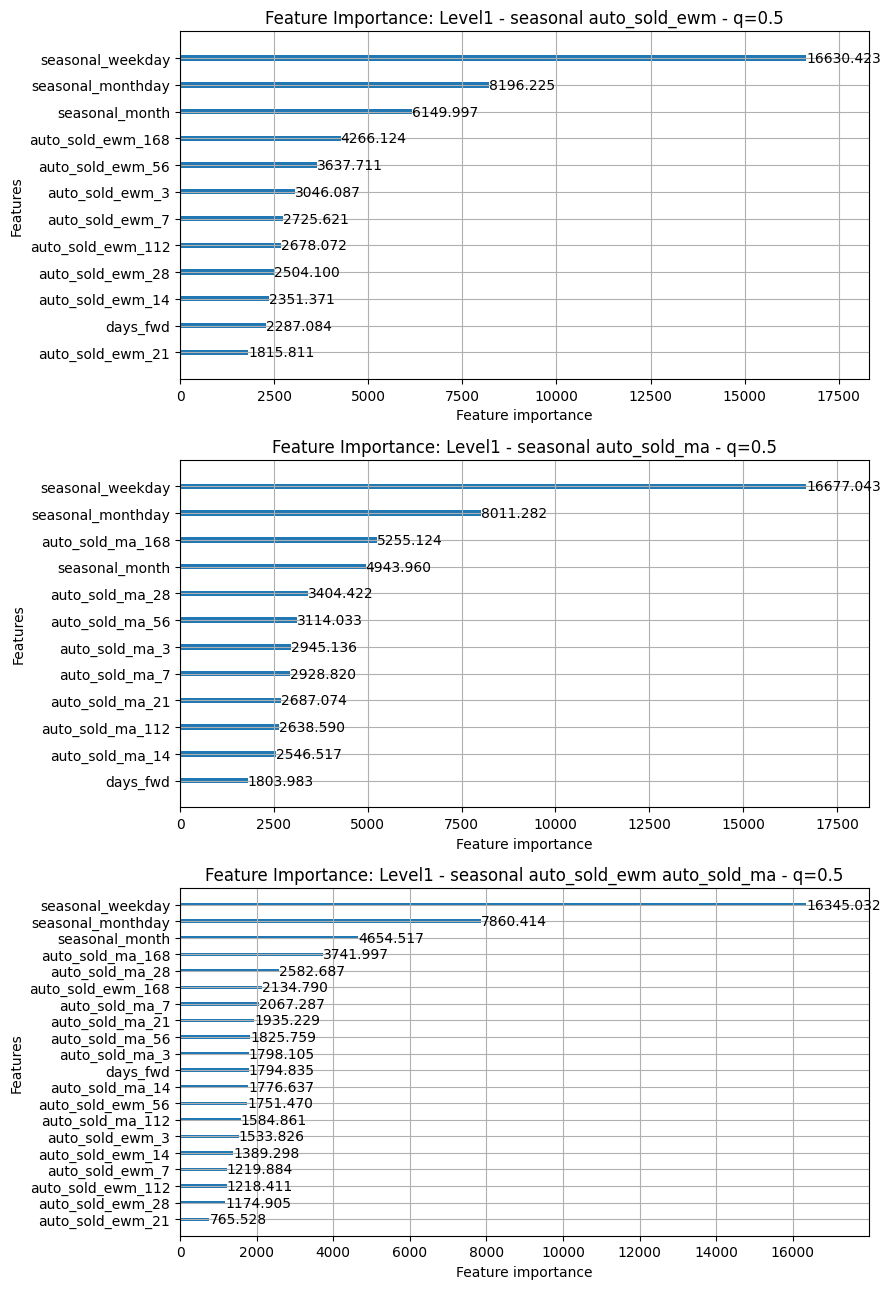

In [26]:

# experiment_name = 'quantiles vs. std'
# experiment_name = 'best models'
# experiment_name = 'full vs. sparse'
experiment_name = 'ewm vs. ma'
# experiment_name = 'state vs. store'
# experiment_name = 'price auto/momentum'
level = 'Level1'
fold = 1886#1886
quantile = .5
models: dict = load_model(experiment_name, level, fold, quantile=quantile)

### TEMP CODE ###
# models.pop('seasonal auto_sold_ma')
# for k in list(models.keys())[-2:]:
#     models.pop(k)
### TEMP CODE ###
n_models = len(models.values())
fig, axs = plt.subplots(n_models,1,figsize=(9,13))
for i, (key, item) in enumerate(models.items()):
    ax = axs[i]
    lgb.plot_importance(item, ax = ax, importance_type='gain')
    ax.set_title(f'Feature Importance: {level} - {key} - q={quantile}')
fig.tight_layout()
plt.savefig(f'../figure/results/importance_{experiment_name.replace("/", "_")}_{level}_{fold}.png', dpi=300)
plt.show()

### Load Predictions and Plot Predictions

In [27]:
def read_concat_predictions(fold_name: int, exclude_columns: list = [], include_columns: list = [], use_all = False, load_submissions_path: str = 'temp_submissions/'):
    """
    For specified fold, read the predictions for all aggregation levels and stack them together in one dataframe.
    """

    exclude_columns = '_'.join(exclude_columns)
    if exclude_columns == '':
        exclude_columns = 'None'

    logger.info('loading files under path:' + f'../data/uncertainty/fold_{fold_name}/' + load_submissions_path)

    dfs: list = []
    for level in list(AGG_LEVEL_COLUMNS.keys())[HIGHEST_LEVEL:HIGHEST_LEVEL+1]:
        agg_columns = AGG_LEVEL_COLUMNS[level]
        group_names = '_'.join(agg_columns)
        if group_names == '':
            group_names = 'Total_X'
        
        file_path = f'../data/uncertainty/fold_{str(fold_name)}/' + load_submissions_path 
        file_path += f'lgb_val_nt_{group_names}_'
        if use_all:
            file_path += f'use_all.csv'  
        elif include_columns == None:
            file_path += f'exclude_{"_".join(exclude_columns)}.csv'            
        elif isinstance(include_columns, list):
            file_path += f'include_{"_".join(include_columns)}.csv'
        
        dfs.append(file_path)
    return ensemble_submissions_uncertainty(dfs)

def perform_cv(df: pd.DataFrame, df_sub: pd.DataFrame):
    
    # to be able to merge
    df_sub['id_merge'] = df_sub['id'].str.split('.')\
        .apply(lambda x: x[0])
    df_sub['quantile'] = df_sub['id'].str.split('.')\
        .apply(lambda x: float('.'.join([x[-2], x[-1].split('_')[0]])))

    # merge predictions in cv template
    p = pd.merge(
        df,
        df_sub,
        how='right',
        on=['id_merge', 'd']
    )

    # for c in ['sold', 'revenue']:
    #     p[c] = p[c].astype(np.float32)
    # d = d[d_int < (D_CV_START + 28)]
    return p

In [28]:
# these variables are used later on
FORCE_RELOAD = False
try:
    # simple code to check if variable exists
    d_int + 1
    if FORCE_RELOAD:
        raise Exception()
except:
    # if not, load again
    # takes about 2-3 minutes to reload and parse
    d = pd.read_parquet('../data/uncertainty/cv_template/temp.parquet')
    d_int = pd.read_parquet('../data/uncertainty/cv_template/temp_d_int.parquet')['d_int']
    # d_int = d['d'].str.split('_').apply(lambda x: int(x[1]))
    # d_int.to_frame('d_int').to_parquet('../data/uncertainty/cv_template/temp_d_int.parquet', index = False)
    d['d_int'] = d_int

In [43]:
# load predictions
FOLD = 1886 #1886 #1802
HIGHEST_LEVEL = 0
# experiment_name = 'price auto/momentum'
experiment_name = 'full vs. sparse'
# experiment_name = 'ewm vs. ma'
# experiment_name = 'state vs. store'
# experiment_name = 'seasonal'
features = EXPERIMENTS_DICT[experiment_name]
idx = 0
INCLUDE_COLUMNS = features['BASE'] + features['INCLUDE_COLUMNS_LIST'][idx]
print(INCLUDE_COLUMNS)
path = 'temp_submissions/'
data = read_concat_predictions(
    FOLD, 
    include_columns=INCLUDE_COLUMNS,
    use_all=False,
    load_submissions_path=path
)
rrr = perform_cv(
    _down_cast(d)[d_int < (FOLD + DAYS)], 
    data
)
rrr = rrr.set_index('d_int', drop=True)

2023-12-22 02:08:52 - __main__ - INFO - loading files under path:../data/uncertainty/fold_1886/temp_submissions/


['seasonal', 'auto_sold_ma', 'auto_sold_std', 'auto_sold_qtile', 'auto_sold_ewm', 'state_id', 'store_id']


In [44]:
rrr.head(5)

,Level,agg_column1,agg_column2,d,sold,revenue,id_merge,id,pred,quantile
d_int,,,,,,,,,,
1886,Level1,Total,X,d_1886,36032.0,114421.179688,Total_X,Total_X.0.005_validation,33100.0,0.005
1887,Level1,Total,X,d_1887,33856.0,105477.882812,Total_X,Total_X.0.005_validation,32450.0,0.005
1888,Level1,Total,X,d_1888,32352.0,101315.742188,Total_X,Total_X.0.005_validation,32430.0,0.005
1889,Level1,Total,X,d_1889,34688.0,108401.679688,Total_X,Total_X.0.005_validation,32220.0,0.005
1890,Level1,Total,X,d_1890,45536.0,144493.921875,Total_X,Total_X.0.005_validation,34880.0,0.005


2023-12-22 02:09:10 - __main__ - INFO - Total_X


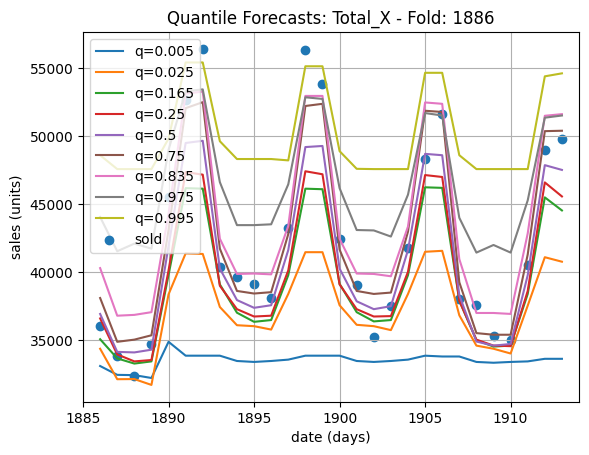

In [45]:
i = 0
# level = 'Level5'
for group, df_temp in rrr.groupby('id_merge'):
    # if df_temp['Level'].iloc[0] != level: continue
    logger.info(group)
    
    # plot 
    for quantile in df_temp['quantile'].unique():
        df_temp[df_temp['quantile'] == quantile]['pred'].plot(label = f'q={quantile}')
        
    # plot actual sales
    idx = df_temp['quantile'] == quantile
    plt.scatter(df_temp[idx].index, df_temp[idx]['sold'], label = f'sold')
    
    # nice graph
    plt.xlim(FOLD-1, FOLD+DAYS)
    plt.grid()
    plt.legend()
    
    plt.title(f'Quantile Forecasts: {group} - Fold: {FOLD}')
    plt.xlabel('date (days)')
    plt.ylabel('sales (units)')
    plt.savefig(f'../figure/results/forecast_{experiment_name}_{"_".join(INCLUDE_COLUMNS)}_{group}_{fold}.png', dpi = 300)
    plt.show()
    
    i += 1
    if i >= 25:
        break

### Load WSPL Scores

In [185]:
experiment_name = 'seasonal'
experiment_name = 'best models'
BASE = EXPERIMENTS_DICT[experiment_name]['BASE']
INCLUDE_COLUMNS_LIST = EXPERIMENTS_DICT[experiment_name]['INCLUDE_COLUMNS_LIST']
INCLUDE_COLUMNS_LIST = [BASE + i for i in INCLUDE_COLUMNS_LIST]

In [12]:
def print_experiment_results(experiment_name, use_all: bool = False, return_table: bool = False, save_table: bool = True):
    if not use_all:
        BASE = EXPERIMENTS_DICT[experiment_name]['BASE']
        INCLUDE_COLUMNS_LIST = EXPERIMENTS_DICT[experiment_name]['INCLUDE_COLUMNS_LIST']
        INCLUDE_COLUMNS_LIST = [BASE + i for i in INCLUDE_COLUMNS_LIST]
        for i,INCLUDE_COLUMNS in enumerate(INCLUDE_COLUMNS_LIST):
            if 'kbest' in INCLUDE_COLUMNS:
                INCLUDE_COLUMNS_LIST[i] = ['k_best']
    
    # load json where all results are stored
    r = load_results_as_json('../data/uncertainty/all_results.json')

    ### create dataframe with all results
    r_all_folds = []
    r_ind_folds = []
    for features_def, results_all_folds in r.items():
        if not use_all:
            if features_def not in ['include_' + ' '.join(i) for i in INCLUDE_COLUMNS_LIST]:
                continue
        features_global_sum = 0
        i = 0
        for fold, fold_results in results_all_folds.items():
            features_fold_sum = 0
            j = 0
            for level, wspl in fold_results.items():
                features_fold_sum += wspl
                j += 1
                features_global_sum += wspl
                i += 1
                if level == MAX_LEVEL_PRINT:
                    break
            r_ind_folds.append([features_def.removeprefix('include_'), fold, features_fold_sum / j, j])
        r_all_folds.append([features_def.removeprefix('include_'), features_global_sum / i])
        
    df_per_fold = pd.DataFrame(r_ind_folds, columns=['features', 'fold', 'avg_wspl', 'n_levels'])
    df_all = df_per_fold.groupby('features')['avg_wspl'].agg([np.average, np.std])
    df_all = df_all.sort_values('average')
    
    # only store table for specific experiments
    if not use_all:
        table_name = experiment_name.replace(' ', '_')
        table_name = experiment_name.replace('/', '_')
        df_all.index = df_all.index.str.replace(' ', ' \& ')
        df_all.index = df_all.index.str.replace('_', ' ')
        if save_table:
            df_all.to_latex(f'../data/uncertainty/tables/{table_name}.tex')
    logger.info(f'----------- experiment: {experiment_name} -----------')
    logger.info('\n' + str(df_all.sort_values('average')))
    if use_all or return_table:
        return df_all

In [13]:
### ALL EXPERIMENTS
MAX_LEVEL_PRINT = 'Level5'
all_experiments = list(EXPERIMENTS_DICT.keys())
print(f'All experiments:\n{all_experiments}')
for experiment_name in all_experiments:
    print_experiment_results(experiment_name, save_table=False)

2023-12-21 21:59:43 - __main__ - INFO - ----------- experiment: seasonal -----------
2023-12-21 21:59:43 - __main__ - INFO - 
                                                     average       std
features                                                              
seasonal \& auto sold ewm                           0.193274  0.042966
seasonal weekday \& seasonal monthday \& auto s...  0.203151  0.047809
seasonal weekday \& auto sold ewm                   0.217514  0.031857
seasonal monthday \& auto sold ewm                  0.321844  0.033581
auto sold ewm                                       0.328331  0.020805
2023-12-21 21:59:43 - __main__ - INFO - ----------- experiment: state vs. store -----------
2023-12-21 21:59:43 - __main__ - INFO - 
                                                   average       std
features                                                            
seasonal \& auto sold ma \& state id \& store id  0.176045  0.039403
seasonal \& auto sold ma \& store id 

All experiments:
['seasonal', 'state vs. store', 'ewm vs. ma', 'quantiles vs. std', 'price auto/momentum', 'best models', 'full vs. sparse ma', 'sparse vs. kbest', 'full vs. sparse']
